# Sandbox for the model speaks

trying to get plot code to work

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from the_model_speaks import *

In [4]:
NUM_ITERS = 8
NUM_TOKENS = 2

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

wandb.init(project="parallel_transformer")
param_file = "../model_files/proto_params.json"

with open(param_file, "r") as f:
    model_args = ModelArgs(**json.loads(f.read()))

model = Transformer(
    model_args, key=jax.random.PRNGKey(1), dtype=jnp.float32
)  

cache_k = jnp.zeros((model_args.max_batch_size, model_args.n_layers, model_args.sliding_window, model_args.n_kv_heads, model_args.head_dim), dtype=jnp.float32)
cache_v = jnp.zeros((model_args.max_batch_size, model_args.n_layers, model_args.sliding_window, model_args.n_kv_heads, model_args.head_dim), dtype=jnp.float32)

tokenizer = Tokenizer("../model_files/tokenizer.model")

# seq generation
res_seq, gen_seq, seq_logits, seq_finals = generate(
    model,
    tokenizer,
    cache_k,
    cache_v,
    model_args.head_dim,
    max_tokens=NUM_TOKENS,
    parallel=False,
    prefill=False,
)
print(f"the output of sequential is : {res_seq}")
print(f"the generated tokens from sequential is : {gen_seq}")

# parr generation
res_parr, gen_parr, parr_logits, parr_finals = generate(model, tokenizer, cache_k, cache_v, model_args.head_dim, max_tokens=NUM_TOKENS, parallel=True, num_iters=NUM_ITERS, prefill=False)
print(f"the output of parallel is : {res_parr}")
print(f"the genrated tokens from parallel is : {gen_parr}")



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Using device: cpu


wandb: Currently logged in as: xavier_gonzalez. Use `wandb login --relogin` to force relogin


Generating...
  rulesULT 

Time taken to generate 2 tokens: 6.64 seconds
the output of sequential is :   rulesULT
the generated tokens from sequential is : [15342, 4874]
Generating...
  rulesULT 

Time taken to generate 2 tokens: 4.84 seconds
the output of parallel is :   rulesULT
the genrated tokens from parallel is : [15342, 4874]


In [12]:
parr_finals[0].squeeze().shape

(8, 32, 64)

In [17]:
parr_finals[0].squeeze()[-1][None,...].shape

(1, 32, 64)

In [14]:
seq_finals[0].squeeze()[None, ...].shape

(1, 32, 64)

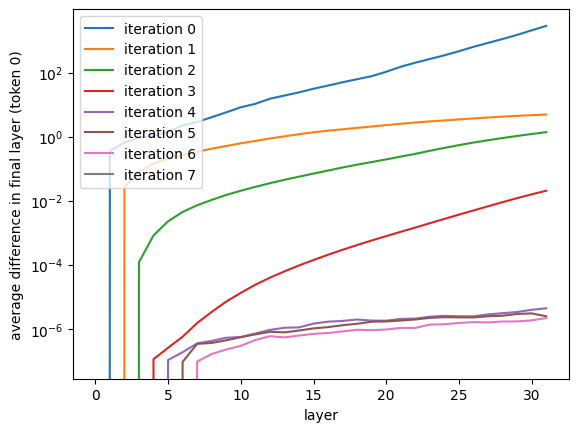

In [ ]:
# converging...but to the wrong target :( 
tok_num = 0
diffs = jnp.mean(
    jnp.abs(parr_finals[0].squeeze()[-1][None, ...] - parr_finals[tok_num].squeeze()),
    axis=(-1),
)
for i in range(len(diffs)):
    plt.plot(diffs[i], label=f"iteration {i}")
plt.legend()
plt.xlabel("layer")
plt.ylabel(f"average difference in final layer (token {tok_num})")
plt.yscale("log")

In [1]:
type(model)

NameError: name 'model' is not defined

In [25]:
h0 = jr.normal(jr.PRNGKey(0), shape=(1,64))
cache_k = jr.normal(
    jr.PRNGKey(0),
    (
        model_args.max_batch_size,
        model_args.n_layers,
        model_args.sliding_window,
        model_args.n_kv_heads,
        model_args.head_dim,
    ),
    dtype=jnp.float32,
)
cache_v = cache_k.copy()

In [26]:
out, _, _ = model.layers[0](h0, cos_freq[pos], sin_freq[pos], pos, None, cache_k[0,0], cache_v[0,0])

In [28]:
partial_layers = model.partial_layers(
    model.layers,
    cos_freq[pos],
    sin_freq[pos],
    pos,
    None,
    cache_k,
    cache_v
)

In [7]:
cos_freq, sin_freq = precompute_frequencies(8, 128000)

In [8]:
cos_freq.shape

(128000, 4)

In [9]:
pos = jnp.array([0])

In [10]:
cos_freq[pos]

Array([[1., 1., 1., 1.]], dtype=float32)